In [7]:
# cv_analysis.ipynb

import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import interact, Dropdown, IntSlider, VBox, HBox

plt.style.use("ggplot")

ROOT = Path("../experiments/oof_results")
FULL_TRAIN_ROOT = Path("../experiments/full_train_results")   # optional, see below


In [8]:
def available_runs(root=ROOT):
    # only directories that actually look like CV runs
    return [
        p.name
        for p in root.iterdir()
        if p.is_dir() and (p / "oof_predictions.csv").exists()
    ]

def load_run(run_name):
    run_dir = ROOT / run_name
    oof_csv = run_dir / "oof_predictions.csv"
    metrics_json = run_dir / "oof_metrics.json"

    oof_df = pd.read_csv(oof_csv)
    with metrics_json.open() as f:
        metrics = json.load(f)

    # Optionally load per-fold CSVs
    fold_files = sorted(run_dir.glob("fold_*_oof.csv"))
    fold_dfs = {f.stem: pd.read_csv(f) for f in fold_files}

    return oof_df, metrics, fold_dfs


def load_full_train_results(root=FULL_TRAIN_ROOT):
    """
    Expected structure:
        experiments/full_train_results/
            run_A/
                val_predictions.csv
                metrics.json
            run_B/
                ...
    """
    if not root.exists():
        return {}
    runs = {}
    for sub in root.iterdir():
        if not sub.is_dir():
            continue
        preds = sub / "val_predictions.csv"
        met = sub / "metrics.json"
        if preds.exists() and met.exists():
            runs[sub.name] = {
                "predictions": pd.read_csv(preds),
                "metrics": json.load(open(met)),
            }
    return runs


In [9]:
cv_runs = available_runs()
full_train_runs = load_full_train_results()

print("CV Runs:", cv_runs)
print("Full-train Runs:", list(full_train_runs.keys()))


CV Runs: ['mini_smoke']
Full-train Runs: []


In [10]:
run_dropdown = Dropdown(options=cv_runs, description="CV Run:")
display(run_dropdown)


Dropdown(description='CV Run:', options=('mini_smoke',), value='mini_smoke')

In [11]:
def show_run_metrics(run_name):
    oof_df, metrics, fold_dfs = load_run(run_name)
    print(f"=== {run_name} ===")
    print("Mean CV:", metrics["mean_cv"])
    print("OOF score:", metrics["oof_score"])
    print("\nPer-fold scores:", metrics["fold_scores"])

    plt.figure(figsize=(6,4))
    plt.bar(range(1, len(metrics["fold_scores"])+1), metrics["fold_scores"])
    plt.xlabel("Fold")
    plt.ylabel("Score")
    plt.title(f"Per-fold Scores: {run_name}")
    plt.show()

    return oof_df, metrics, fold_dfs

interact(show_run_metrics, run_name=run_dropdown)


interactive(children=(Dropdown(description='CV Run:', options=('mini_smoke',), value='mini_smoke'), Output()),…

<function __main__.show_run_metrics(run_name)>

In [12]:
# GT_PATH = "data/train_solution.csv"  # or generate same as build_solution_df
# gt_df = pd.read_csv(GT_PATH)

# def compute_errors(pred_df, gt_df):
#     merged = gt_df.merge(pred_df, on="row_id", suffixes=("_gt", "_pred"))
#     merged["is_correct"] = merged["annotation_gt"] == merged["annotation_pred"]
#     return merged

# def show_error_stats(run_name):
#     pred_df, metrics, _ = load_run(run_name)
#     merged = compute_errors(pred_df, gt_df)

#     acc = merged["is_correct"].mean()
#     print(f"Accuracy (strict equality): {acc:.4f}")

#     forged_gt = merged[merged["annotation_gt"]!="authentic"]
#     authentic_gt = merged[merged["annotation_gt"]=="authentic"]

#     forged_acc = (forged_gt["annotation_gt"] == forged_gt["annotation_pred"]).mean()
#     authentic_acc = (authentic_gt["annotation_gt"] == authentic_gt["annotation_pred"]).mean()

#     print("Forged accuracy:", forged_acc)
#     print("Authentic accuracy:", authentic_acc)

#     # display bar chart
#     plt.figure(figsize=(6,4))
#     plt.bar(["All","Forged","Authentic"], [acc, forged_acc, authentic_acc])
#     plt.title(f"Error breakdown: {run_name}")
#     plt.ylim(0, 1)
#     plt.show()

# interact(show_error_stats, run_name=run_dropdown)


In [13]:
# def misclassified_viewer(run_name):
#     pred_df, metrics, _ = load_run(run_name)
#     merged = compute_errors(pred_df, gt_df)
#     mis = merged[~merged["is_correct"]]

#     ids = mis["row_id"].tolist()
#     if not ids:
#         print("No misclassifications—nice!")
#         return
    
#     def show_sample(row_id):
#         row = mis[mis["row_id"] == row_id].iloc[0]
#         print("GT:", row["annotation_gt"])
#         print("Pred:", row["annotation_pred"])
#         # optionally show the image and masks
#         # display(Image.open(path_to_image(row_id)))
    
#     interact(show_sample, row_id=Dropdown(options=ids, description="row_id"))

# interact(misclassified_viewer, run_name=run_dropdown)


In [14]:
def compare_runs(run_a, run_b):
    a_df, a_met, _ = load_run(run_a)
    b_df, b_met, _ = load_run(run_b)

    print(f"{run_a} – OOF: {a_met['oof_score']}")
    print(f"{run_b} – OOF: {b_met['oof_score']}")

    plt.figure(figsize=(6,4))
    plt.bar(["A","B"], [a_met["oof_score"], b_met["oof_score"]])
    plt.title("OOF Comparison")
    plt.show()

interact(compare_runs,
         run_a=Dropdown(options=cv_runs),
         run_b=Dropdown(options=cv_runs))


interactive(children=(Dropdown(description='run_a', options=('mini_smoke',), value='mini_smoke'), Dropdown(des…

<function __main__.compare_runs(run_a, run_b)>

In [15]:
def compare_cv_full(cv_run, full_run):
    pred_df, cv_metrics, _ = load_run(cv_run)
    f = full_train_runs[full_run]

    print("CV OOF:", cv_metrics["oof_score"])
    print("Full-train validation:", f["metrics"].get("val_score", "N/A"))

    plt.figure(figsize=(6,4))
    plt.bar(["CV OOF", "Full Train"], [cv_metrics["oof_score"], f["metrics"]["val_score"]])
    plt.title(f"{cv_run} vs {full_run}")
    plt.show()

interact(compare_cv_full,
         cv_run=Dropdown(options=cv_runs),
         full_run=Dropdown(options=list(full_train_runs.keys())))


interactive(children=(Dropdown(description='cv_run', options=('mini_smoke',), value='mini_smoke'), Dropdown(de…

<function __main__.compare_cv_full(cv_run, full_run)>

In [16]:
def fold_drill(run_name, fold_number):
    _, _, fold_dfs = load_run(run_name)
    key = f"fold_{fold_number}_oof"
    if key not in fold_dfs:
        print("No per-fold file found.")
        return

    fold_df = fold_dfs[key]
    print("Rows:", len(fold_df))
    display(fold_df.head())

interact(
    fold_drill,
    run_name=run_dropdown,
    fold_number=IntSlider(min=1, max=5, step=1, value=1)
)


interactive(children=(Dropdown(description='CV Run:', options=('mini_smoke',), value='mini_smoke'), IntSlider(…

<function __main__.fold_drill(run_name, fold_number)>

In [17]:
# Resolve path relative to this notebook (notebooks/cv_analysis.ipynb)
csv_path = Path("..") / "experiments" / "cls_threshold_sweep" / "cls_threshold_sweep.csv"

df = pd.read_csv(csv_path)

# Quick sanity check
display(df.head())
print(f"Loaded {len(df)} rows")
print(df.columns.tolist())

,gate,cls_threshold,mask_threshold,idx_in_batch,gate_pass,num_keep,max_cls_prob,max_mask_prob,any_fg_pre_keep,any_fg_post_keep,image_forged_prob
0,-1.0,0.05,0.5,0,1,15,0.130176,1.000000,1,1,0.613294
1,-1.0,0.05,0.5,1,1,15,0.201880,0.999997,1,1,0.474688
2,-1.0,0.05,0.5,2,1,0,0.029606,0.998738,1,0,0.186493
3,-1.0,0.05,0.5,3,1,0,0.020249,0.999816,1,0,0.017884
4,-1.0,0.05,0.5,0,1,15,0.162346,0.632276,1,1,0.607723


Loaded 51760 rows
['gate', 'cls_threshold', 'mask_threshold', 'idx_in_batch', 'gate_pass', 'num_keep', 'max_cls_prob', 'max_mask_prob', 'any_fg_pre_keep', 'any_fg_post_keep', 'image_forged_prob']


In [18]:
df['cls_threshold'].value_counts()

cls_threshold
0.05    5176
0.10    5176
0.20    5176
0.30    5176
0.40    5176
0.50    5176
0.60    5176
0.70    5176
0.80    5176
0.90    5176
Name: count, dtype: int64

In [19]:
# aggregate per cls_threshold across all images
summary = (
    df.groupby("cls_threshold")
      .agg(
          gate_pass_rate=("gate_pass", "mean"),
          avg_num_keep=("num_keep", "mean"),
          any_fg_pre_rate=("any_fg_pre_keep", "mean"),
          any_fg_post_rate=("any_fg_post_keep", "mean"),
          avg_max_cls_prob=("max_cls_prob", "mean"),
          avg_max_mask_prob=("max_mask_prob", "mean"),
          avg_image_forged_prob=("image_forged_prob", "mean"),
      )
      .reset_index()
      .sort_values("cls_threshold")
)

display(summary)

,cls_threshold,gate_pass_rate,avg_num_keep,any_fg_pre_rate,any_fg_post_rate,avg_max_cls_prob,avg_max_mask_prob,avg_image_forged_prob
0,0.05,1.0,10.989181,0.96194,0.729328,0.135911,0.95336,0.527448
1,0.10,1.0,9.518740,0.96194,0.641422,0.135911,0.95336,0.527448
2,0.20,1.0,0.935085,0.96194,0.232419,0.135911,0.95336,0.527448
3,0.30,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
4,0.40,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
5,0.50,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
6,0.60,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
7,0.70,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
8,0.80,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
9,0.90,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448


In [23]:
# --- path fix for notebooks/ ---
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


,batch,i,image_label,img_forged_prob,cls_max,cls_mean,cls_std,mask_max,keep_rate@0.1,num_keep@0.1,keep_rate@0.2,num_keep@0.2,keep_rate@0.3,num_keep@0.3
0,0,0,1.0,0.981485,0.098323,0.095916,0.001380,0.913641,0.0,0,0.0,0,0.0,0
1,0,1,0.0,0.005336,0.014971,0.011402,0.001364,0.978581,0.0,0,0.0,0,0.0,0
2,0,2,1.0,0.998947,0.144757,0.144115,0.000657,0.455432,1.0,15,0.0,0,0.0,0
3,0,3,0.0,0.524180,0.090772,0.089676,0.000679,0.836413,0.0,0,0.0,0,0.0,0
4,1,0,1.0,0.526132,0.075407,0.071173,0.001699,0.311526,0.0,0,0.0,0,0.0,0


,batch,i,image_label,img_forged_prob,cls_max,cls_mean,cls_std,mask_max,keep_rate@0.1,num_keep@0.1,keep_rate@0.2,num_keep@0.2,keep_rate@0.3,num_keep@0.3
count,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.0,200.0,200.0
mean,24.500000,1.50000,0.470000,0.472429,0.083398,0.080438,0.002005,0.445550,0.314000,4.710000,0.0,0.0,0.0,0.0
std,14.467083,1.12084,0.500352,0.405648,0.037990,0.038305,0.001730,0.352583,0.454598,6.818973,0.0,0.0,0.0,0.0
min,0.000000,0.00000,0.000000,0.000005,0.001228,0.000821,0.000092,0.000106,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,24.500000,1.50000,0.000000,0.493023,0.087378,0.084305,0.001269,0.420051,0.000000,0.000000,0.0,0.0,0.0,0.0
90%,44.100000,3.00000,1.000000,0.999156,0.132609,0.131028,0.004771,0.946924,1.000000,15.000000,0.0,0.0,0.0,0.0
95%,47.000000,3.00000,1.000000,0.999770,0.141049,0.138574,0.005385,0.968099,1.000000,15.000000,0.0,0.0,0.0,0.0
99%,49.000000,3.00000,1.000000,0.999937,0.145846,0.144366,0.006756,0.989308,1.000000,15.000000,0.0,0.0,0.0,0.0
max,49.000000,3.00000,1.000000,0.999990,0.156808,0.152357,0.009206,0.993174,1.000000,15.000000,0.0,0.0,0.0,0.0


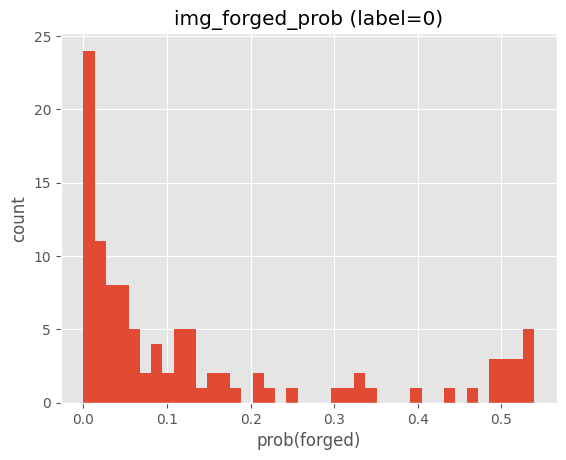

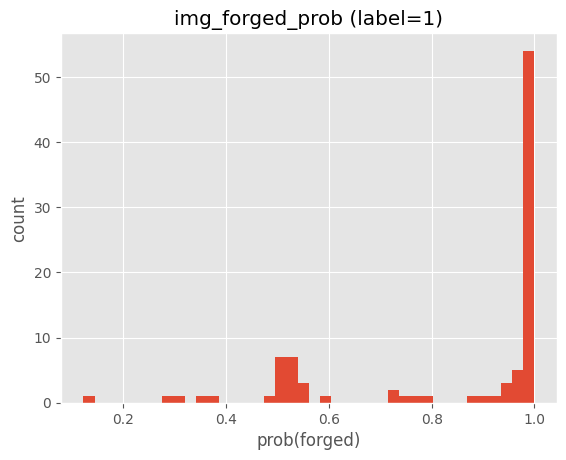

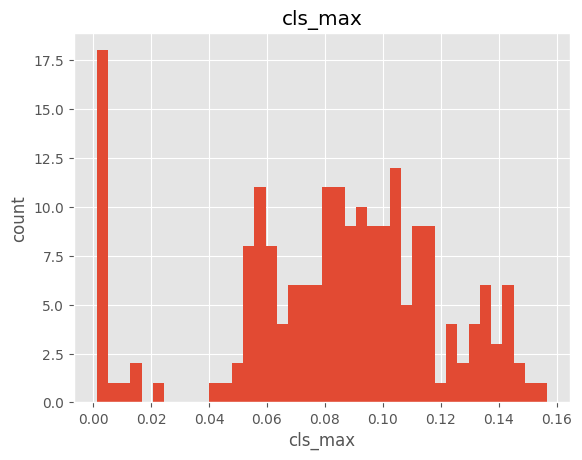

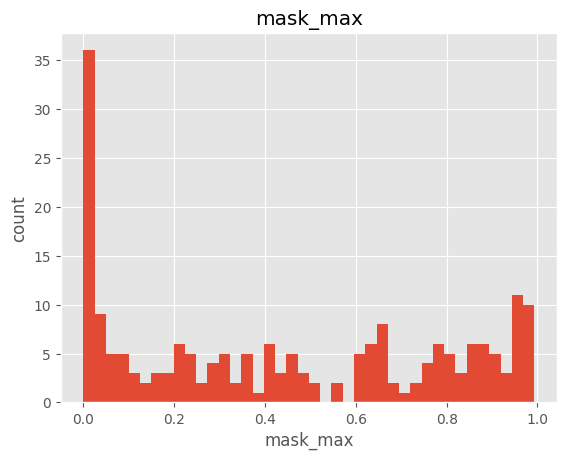

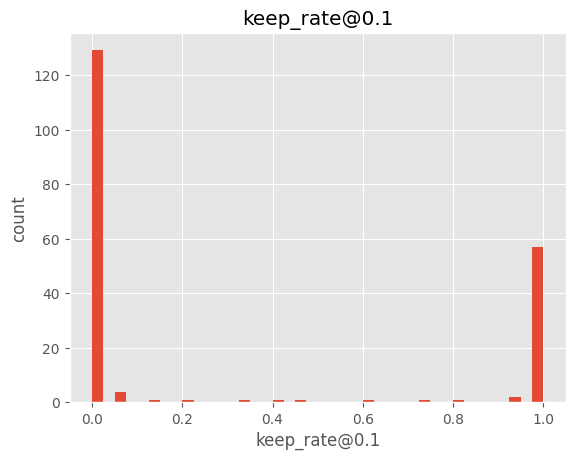

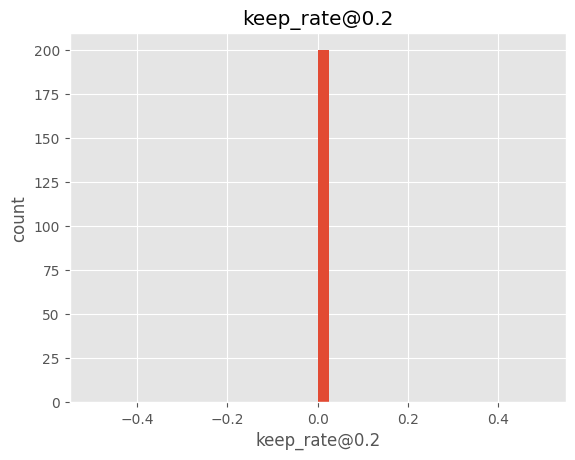

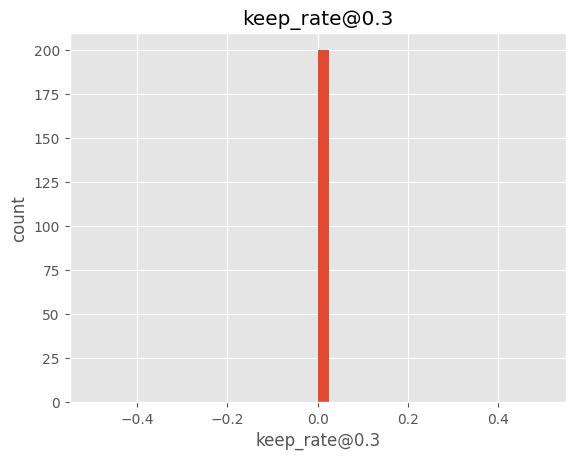

cls_max_mean            0.083398
cls_max_p95             0.141049
img_forged_prob_mean    0.472429
img_forged_prob_p95     0.999770
mask_max_mean           0.445550
mask_max_p95            0.968099
dtype: float64
per-image cls_prob std: mean= 0.0020051022681247753  p05= 0.0002723973543026954


In [26]:
# --- CV analysis: inspect logits + collapse-style debug stats ---
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from src.data.dataloader import ForgeryDataset, get_val_transform, detection_collate_fn
from src.models.mask2former_v1 import Mask2FormerForgeryModel


def build_full_eval_loader(
    data_root="data",
    img_size=256,
    batch_size=4,
    num_workers=4,
):
    authentic_path = os.path.join(data_root, "train_images", "authentic")
    forged_path = os.path.join(data_root, "train_images", "forged")
    masks_path = os.path.join(data_root, "train_masks")
    supp_forged_path = os.path.join(data_root, "supplemental_images")
    supp_masks_path = os.path.join(data_root, "supplemental_masks")

    ds = ForgeryDataset(
        authentic_path=authentic_path,
        forged_path=forged_path,
        masks_path=masks_path,
        supp_forged_path=supp_forged_path if os.path.isdir(supp_forged_path) else None,
        supp_masks_path=supp_masks_path if os.path.isdir(supp_masks_path) else None,
        transform=get_val_transform(img_size=img_size),
        is_train=False,
    )

    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True,  # shuffle so repeated runs don't stare at same few images
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=detection_collate_fn,  # list[Tensor], list[dict]
        persistent_workers=(num_workers > 0),
    )
    return ds, loader


def load_model(weights_path, device):
    model = Mask2FormerForgeryModel(
        num_queries=15,
        d_model=256,
        backbone_trainable=False,          # inference-style for analysis
        authenticity_penalty_weight=5.0,
        auth_gate_forged_threshold=0.5,
        default_mask_threshold=0.5,
        default_cls_threshold=0.5,
    ).to(device)

    state = torch.load(weights_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model


@torch.no_grad()
def collect_logit_stats(model, loader, device, num_batches=50, cls_thrs=(0.1, 0.2, 0.3)):
    """
    Returns:
      df_img: per-image rows (best for plotting / debugging collapse)
      df_query: optional per-query rows (heavier; use only if needed)
    """
    rows_img = []
    rows_query = []

    it = iter(loader)
    for b in range(num_batches):
        images, targets = next(it)
        images = [x.to(device, non_blocking=True) for x in images]

        mask_logits, class_logits, img_logits = model.forward_logits(images)

        cls_probs = class_logits.sigmoid()               # [B,Q]
        img_probs = img_logits.sigmoid()                 # [B]
        mask_probs = mask_logits.sigmoid().flatten(2)    # [B,Q,HW]

        # image-level summaries (mirrors train_full debug intent)
        cls_max = cls_probs.max(dim=1).values            # [B]
        mask_max = mask_probs.max(dim=2).values.max(dim=1).values  # [B]
        cls_mean = cls_probs.mean(dim=1)                 # [B]
        cls_std  = cls_probs.std(dim=1)                  # [B]

        # target info (authentic vs forged)
        y = torch.stack([t["image_label"].float() for t in targets]).cpu().numpy()

        for i in range(len(images)):
            r = {
                "batch": b,
                "i": i,
                "image_label": float(y[i]),                 # 0 authentic / 1 forged
                "img_forged_prob": float(img_probs[i].item()),
                "cls_max": float(cls_max[i].item()),
                "cls_mean": float(cls_mean[i].item()),
                "cls_std": float(cls_std[i].item()),
                "mask_max": float(mask_max[i].item()),
            }
            for thr in cls_thrs:
                r[f"keep_rate@{thr}"] = float((cls_probs[i] > thr).float().mean().item())
                r[f"num_keep@{thr}"] = int((cls_probs[i] > thr).sum().item())
            rows_img.append(r)

        # per-query (optional but useful if collapse is “all queries identical”)
        # comment this block out if you want it lighter
        B, Q = cls_probs.shape
        for bi in range(B):
            for q in range(Q):
                rows_query.append({
                    "batch": b,
                    "i": bi,
                    "q": q,
                    "image_label": float(y[bi]),
                    "img_forged_prob": float(img_probs[bi].item()),
                    "cls_prob": float(cls_probs[bi, q].item()),
                    "mask_prob_mean": float(mask_probs[bi, q].mean().item()),
                    "mask_prob_max": float(mask_probs[bi, q].max().item()),
                })

    df_img = pd.DataFrame(rows_img)
    df_query = pd.DataFrame(rows_query)
    return df_img, df_query


def quick_plots(df_img):
    # 1) forged-prob distribution split by label
    for lbl in [0.0, 1.0]:
        sub = df_img[df_img["image_label"] == lbl]
        plt.figure()
        plt.hist(sub["img_forged_prob"].values, bins=40)
        plt.title(f"img_forged_prob (label={int(lbl)})")
        plt.xlabel("prob(forged)")
        plt.ylabel("count")
        plt.show()

    # 2) cls_max and mask_max (collapse detectors)
    for col in ["cls_max", "mask_max"]:
        plt.figure()
        plt.hist(df_img[col].values, bins=40)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("count")
        plt.show()

    # 3) keep-rate sanity
    keep_cols = [c for c in df_img.columns if c.startswith("keep_rate@")]
    for col in keep_cols:
        plt.figure()
        plt.hist(df_img[col].values, bins=40)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("count")
        plt.show()


# ---------------------------
# Run it
# ---------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHTS = "../weights/full_train/model_full_data_baseline.pth"  # adjust if needed
DATA_ROOT = "../data"  # adjust if needed

ds, loader = build_full_eval_loader(data_root=DATA_ROOT, img_size=256, batch_size=4, num_workers=4)
model = load_model(WEIGHTS, DEVICE)

df_img, df_query = collect_logit_stats(model, loader, DEVICE, num_batches=50)
display(df_img.head())
display(df_img.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

quick_plots(df_img)

# Useful “collapse checks” at a glance:
summary = {
    "img_forged_prob_mean": df_img["img_forged_prob"].mean(),
    "img_forged_prob_p95": df_img["img_forged_prob"].quantile(0.95),
    "cls_max_mean": df_img["cls_max"].mean(),
    "cls_max_p95": df_img["cls_max"].quantile(0.95),
    "mask_max_mean": df_img["mask_max"].mean(),
    "mask_max_p95": df_img["mask_max"].quantile(0.95),
}
print(pd.Series(summary).sort_index())

# If you suspect "all queries are the same", check per-image variance across queries:
per_image_cls_std = df_query.groupby(["batch","i"])["cls_prob"].std()
print("per-image cls_prob std: mean=", per_image_cls_std.mean(), " p05=", per_image_cls_std.quantile(0.05))
